# Flower Image Classification
**Pytorch** implementation of an image classifier for identification of flower species with deep learning. It is trained on **102 flower categories** from [Oxford Flower Dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html). To obtain higher accuracy of our model we take advantage of **transfer learning** with a **pretrained network**. 

The project is the final assigment for Udacity [PyTorch Scholarship Challenge](https://www.udacity.com/facebook-pytorch-scholarship).

This notebook is divided into **3 sections**:
* Data loading and preprocessing
* Building and training a model
* Using the model for inference



### Import Dependencies 

In [0]:
import torch, torchvision
from torch import nn, optim
from torchvision import models, transforms
from torch.optim import lr_scheduler

import numpy as np
import time
import json
import math

import PIL
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [0]:
# Check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if train_on_gpu:
    print('CUDA is available! Training on GPU.')
else:
    print('CUDA is not available. Training on CPU.')    

CUDA is available!  Training on GPU.


## Load and Preprocess the Data
The dataset is split into three parts - **training**, **validation** and **test sets**. Training set is used to train a model, validation set to choose the right hyperparameters and test set to estimate final accuracy. Each set has already a structure needed by ImageFolder, for example: `train/class/image`


Images are **resized and cropped** to 224x224 pixels and **normalized** by mean \[0.485, 0.456, 0.406] and standard deviation \[0.229, 0.224, 0.225] (values for each color channel) as required by pretrained network.

In addition, training data is **augmented** by random resize, crop, rotation and horizontal flip transformations. 

In [0]:
data_dir = 'flower_data/'
phases = ['train', 'valid', 'test']
dirs = {phase: data_dir + phase for phase in phases}

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

batch_size = 16

# Define transforms
data_transforms = {
    'train' : transforms.Compose([
            transforms.RandomRotation(30),
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
    ]),
    'valid' : transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
    ]),
    'test' : transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
    ])
}   

# Load the datasets
image_datasets = {
    phase: torchvision.datasets.ImageFolder(dirs[phase], 
           transform = data_transforms[phase]) for phase in phases}
   
# Prepare batches of data with DataLoaders
dataloaders = {
    phase: torch.utils.data.DataLoader(image_datasets[phase], 
         batch_size = batch_size, shuffle = True) for phase in phases}

# Get mapping from classes (folder names) to dataset indices (labels)
class_to_idx = dataloaders['test'].dataset.class_to_idx
idx_to_class = {class_to_idx[str(c)] : c for c in class_to_idx}

In [0]:
# Load flower names
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

### Visualize the Data
First, we display a few images of flowers with their names before training the network.

In [0]:
def unnormalize(image):
    """
    Transform an image back to original (unnormalized) values.
    
    :param image: numpy image to transform
    :return: transformed image
    """
    np_std = np.array(std).reshape(3, 1, 1)
    np_mean = np.array(mean).reshape(3, 1, 1)

    image = image * np_std + np_mean
    image = image.clip(0, 1)
    return image

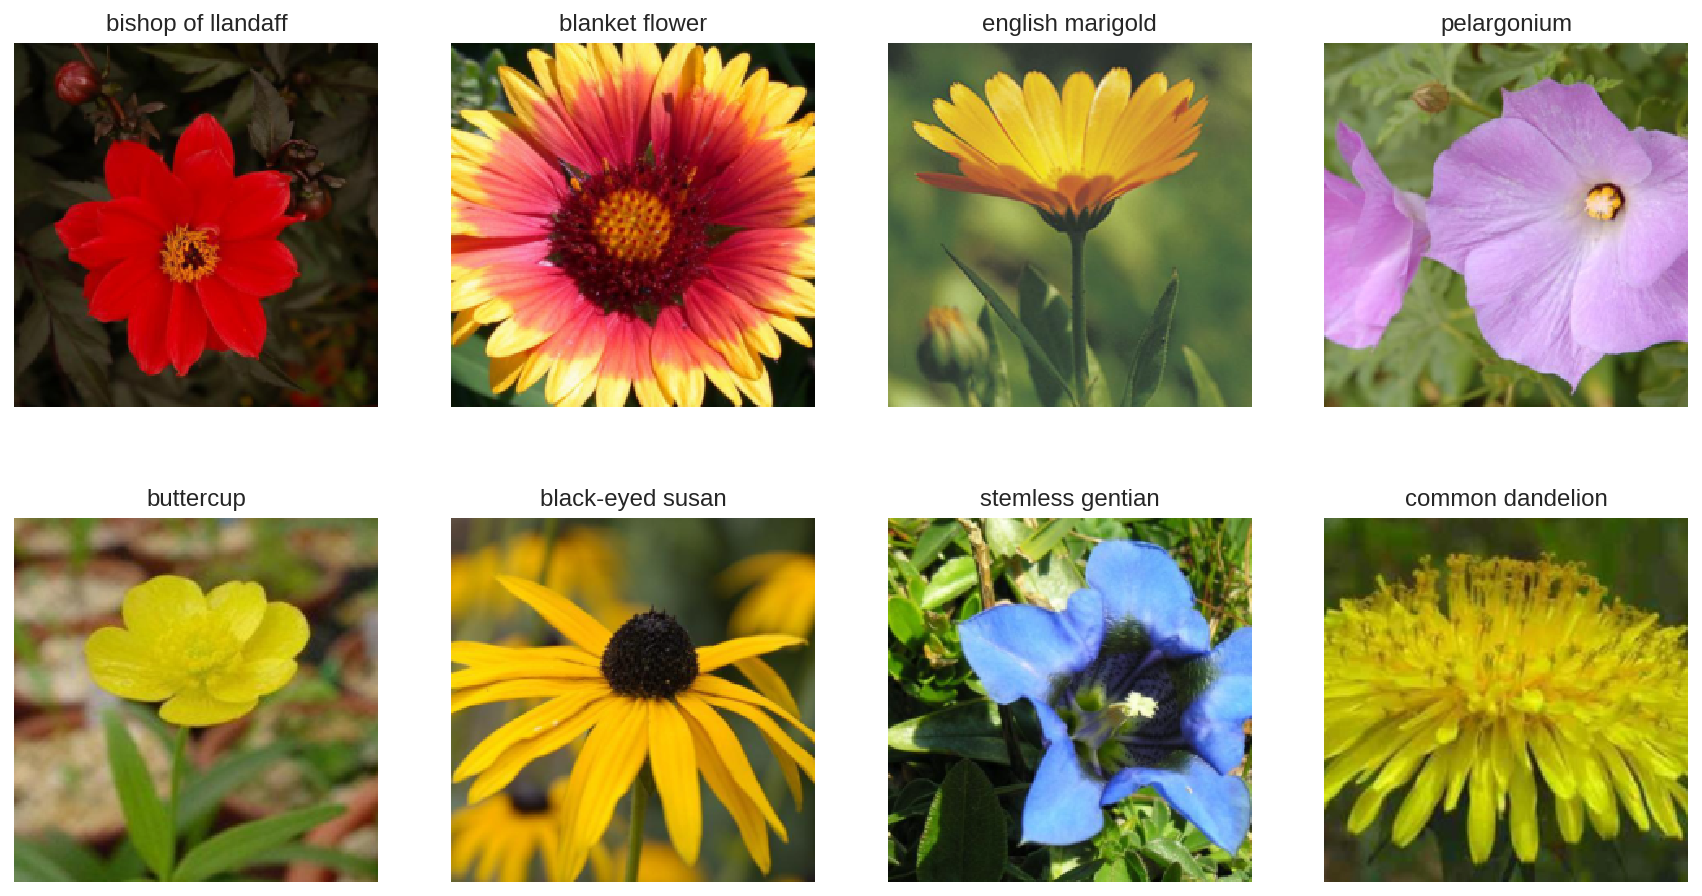

In [0]:
# Get a batch of images
images, labels = next(iter(dataloaders['valid']))

images = images.numpy()
num_of_images = 8
fig = plt.figure(figsize = (15, 8))  

# Display images and names of the flowers
for i in range(num_of_images):
    ax = fig.add_subplot(2, 4, i+1, xticks=[], yticks=[])
    ax.imshow(unnormalize(images[i]).transpose((1, 2, 0)))
    
    # Get a class from a label
    c = idx_to_class[labels[i].item()]
    ax.set_title(cat_to_name[c])

## Build and Train the Neural Network
As our network architecture, we use **pretrained ResNet152** where we replace the fully connected layers with a newly **defined classifier** to be trained on our data.

In [0]:
def build_model(drop):
    """
    Builds and returns pretrained ResNet152 model with a new 2-layer classifier
    and LogSoftmax as the final activation function
    
    :param drop: dropout rate (0-1) between the two fully connected layers
    :return: pretrained ResNet152 model with a new classifier
    """
    
    # Load pretrained ResNet152
    model = models.resnet152(pretrained = True)
    
    # Define a new classifier
    classifier = nn.Sequential(nn.Linear(2048, 2048),
                           nn.Dropout(drop),
                           nn.ReLU(),
                           nn.Linear(2048, 102),
                           nn.LogSoftmax(dim=1))

    # Replace the old one
    model.fc = classifier
    
    # Move model to GPU
    if train_on_gpu:
        model.cuda()
        
    return model

In [0]:
def freeze_parameters(model, freeze_model, freeze_classifier):
    """
    Freezes/unfreezes parameters of a model for training. Frozen parameters will
    not train.
    
    :param model: model with parameters to freeze
    :param freeze_model: bool, if True, freezes the whole model
    :param freeze_classifier: bool, if True, freezes the classifier
    """
    
    # Freeze model
    for param in model.parameters():
        param.requires_grad = not freeze_model
        
    # Freeze classifier
    for param in model.fc.parameters():
        param.requires_grad = not freeze_classifier


We train the model for a number of epochs. After each epoch we compute **validation loss** on the validation dataset. If it **decreases**, we **save** the model parameters to a checkpoint.

In [0]:
def train(model, dataloaders, epochs, optimizer, scheduler, save_path, 
          load_path = None):
    """
    Trains a model
    
    :param model: model to train
    :param dataloaders: DataLoaders with training and validation datasets
    :param epochs: number of epochs to train
    :param optimizer: optimizer for optimization of model parameters
    :param scheduler: scheduler for decreasing the learning rate
    :param save_path: destination for saving a model
    :param load_path: path of a checkpoint with saved parameters of a model 
        to train further
    :return: training and validation losses and accuracies for each batch
    """
    
    if load_path is None:
        # Training from the beginning
        starting_epoch = 0
        min_loss = math.inf
    else:
        # Load data from checkpoint
        checkpoint = torch.load(load_path)
        model.load_state_dict(checkpoint['state_dict'])
        starting_epoch = checkpoint['epochs']
        min_loss = checkpoint['loss']

    # Keep track of accuracy and training and validation loss
    train_losses, valid_losses, accuracies = [], [], []
    
    for epoch in range(starting_epoch, starting_epoch + epochs):
        start_time = time.time()     
        
        # Train model
        train_loss = 0;
        model.train()
        scheduler.step()
        for images, labels in dataloaders['train']:
            optimizer.zero_grad()
            if (train_on_gpu):
                images, labels = images.cuda(), labels.cuda()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            train_loss += float(loss)

            # Backpropagation and weight update
            loss.backward()
            optimizer.step()


        # Validation
        model.eval()
        valid_loss = 0;
        accuracy = 0

        with torch.no_grad():
            for images, labels in dataloaders['valid']:
                if (train_on_gpu):
                    images, labels = images.cuda(), labels.cuda()

                # Forward pass
                outputs = model(images)
                loss = criterion(outputs, labels)
                valid_loss += float(loss)

                # Compute accuracy
                _, preds = torch.max(outputs, 1)
                equals = preds == labels.data
                accuracy += torch.sum(equals.type(torch.FloatTensor))
        
        print(('Epoch {}/{}, Training loss: {:.3f}, Validation loss: {:.3f}, ' \
               'Accuracy: {:.2f}%, Time: {:.0f} s').format(
                    epoch + 1,
                    epochs + starting_epoch,
                    train_loss / len(dataloaders['train'].dataset),
                    valid_loss / len(dataloaders['valid'].dataset),
                    100 * accuracy / len(dataloaders['valid'].dataset),
                    time.time() - start_time))
        
        #if valid_loss/len(dataloaders['valid'].dataset) < min_loss:
        #    print('   Validation loss decreased, saving model')       

        # Save model weights if validation loss decreased
        if valid_loss/len(dataloaders['valid'].dataset) < min_loss:
            min_loss = valid_loss/len(dataloaders['valid'].dataset)
            save_model()

        # Save losses and accuracy
        train_losses.append(train_loss/len(dataloaders['train'].dataset))
        valid_losses.append(valid_loss/len(dataloaders['valid'].dataset))
        accuracies.append(accuracy/len(dataloaders['valid'].dataset))
        
    return train_losses, valid_losses, accuracies

### Define Model Hyperparameters

In [0]:
# Hyperparameters for training
epochs = 10
drop = 0.1
lr = 1e-03

# Hyperparameters for fine-tunig
epochs_ft = 10
lr_ft = 1e-05

# Hyperparameters for the scheduler
step = 5
gamma = 0.2

### Define Optimizer, Loss and Scheduler
We use Adam optimizer, NLLLoss and StepLR scheduler with hyperparameters defined above.

In [0]:
def get_optimizer(model, lr):
    """
    Returns an optimizer for all unfrozen parameters of a model with a learning 
    rate 
    
    :param model: model to optimize
    :param lr: learning rate 
    :return: optimizer
    """
    
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    return optim.Adam(parameters, lr)

In [0]:
model = build_model(drop)
optimizer = get_optimizer(model, lr)
criterion = nn.NLLLoss(reduction='sum')
scheduler = lr_scheduler.StepLR(optimizer, step, gamma)

### Train the Model
First, we freeze the CNN part of the network and train **only the classifier**.

In [0]:
checkpoint_path = 'checkpoint.pth'

freeze_parameters(model, freeze_model = True, freeze_classifier = False)
train_losses, valid_losses, accuracies = train(
    model, dataloaders, epochs, optimizer, scheduler, checkpoint_path)

Epoch 1/10, Training loss: 2.843, Validation loss: 1.093, Accuracy: 70.29%, Time: 229 s
Epoch 2/10, Training loss: 1.316, Validation loss: 0.581, Accuracy: 86.31%, Time: 228 s
Epoch 3/10, Training loss: 1.061, Validation loss: 0.535, Accuracy: 85.82%, Time: 228 s
Epoch 4/10, Training loss: 0.903, Validation loss: 0.434, Accuracy: 87.90%, Time: 229 s
Epoch 5/10, Training loss: 0.793, Validation loss: 0.405, Accuracy: 89.12%, Time: 229 s
Epoch 6/10, Training loss: 0.639, Validation loss: 0.268, Accuracy: 93.64%, Time: 230 s
Epoch 7/10, Training loss: 0.581, Validation loss: 0.263, Accuracy: 93.52%, Time: 229 s
Epoch 8/10, Training loss: 0.570, Validation loss: 0.259, Accuracy: 93.52%, Time: 229 s
Epoch 9/10, Training loss: 0.581, Validation loss: 0.261, Accuracy: 93.03%, Time: 229 s
Epoch 10/10, Training loss: 0.561, Validation loss: 0.253, Accuracy: 93.89%, Time: 229 s


When the classifier is trained, we can unfreeze the CNN part and **fine-tune** the whole network to get better accuracy. We should use much **lower learning rate**.

In [0]:
freeze_parameters(model, freeze_model = False, freeze_classifier = False)
optimizer_ft = get_optimizer(model, lr_ft)
train_losses_ft, valid_losses_ft, accuracies_ft = train(
    model, dataloaders, epochs_ft, optimizer_ft, scheduler, checkpoint_path,
    checkpoint_path)

Epoch 11/20, Training loss: 0.465, Validation loss: 0.183, Accuracy: 95.60%, Time: 537 s
Epoch 12/20, Training loss: 0.354, Validation loss: 0.145, Accuracy: 96.45%, Time: 536 s
Epoch 13/20, Training loss: 0.313, Validation loss: 0.137, Accuracy: 97.19%, Time: 535 s
Epoch 14/20, Training loss: 0.266, Validation loss: 0.125, Accuracy: 97.56%, Time: 536 s
Epoch 15/20, Training loss: 0.250, Validation loss: 0.111, Accuracy: 97.92%, Time: 539 s
Epoch 16/20, Training loss: 0.234, Validation loss: 0.107, Accuracy: 97.68%, Time: 540 s
Epoch 17/20, Training loss: 0.199, Validation loss: 0.097, Accuracy: 98.04%, Time: 540 s
Epoch 18/20, Training loss: 0.186, Validation loss: 0.103, Accuracy: 98.41%, Time: 541 s
Epoch 19/20, Training loss: 0.182, Validation loss: 0.098, Accuracy: 98.04%, Time: 539 s
Epoch 20/20, Training loss: 0.182, Validation loss: 0.091, Accuracy: 98.29%, Time: 538 s


In [0]:
# Load the best model
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['state_dict'])

### Evaluate the Model
To better **visualize** the training process and to find out if the model is **overfitting or underfitting**, it's useful to **plot** model **loss** and **accuracy** throughout the training. First, we display data from the training of the **classifier**.

In [0]:
def plot_graphs(epoch_labels, train_losses, valid_losses, accuracies):
    """
    Plots losses and accuracy graphs
    
    :param epoch_labels: labels for x-axis
    :param train_losses: values of training loss
    :param valid_losses: values of validation loss
    :param accuracies: values of accuracy
    """
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Plot losses
    ax1.plot(epoch_labels, train_losses, label = 'Training loss')
    ax1.plot(epoch_labels, valid_losses, label = 'Validation loss')
    ax1.set_xlabel('Epochs')
    ax1.set_title('Training and Validation loss')
    ax1.legend()

    # Plot accuracy
    ax2.plot(epoch_labels, accuracies, color = 'brown', label = 'Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_title('Accuracy')
    ax2.legend();

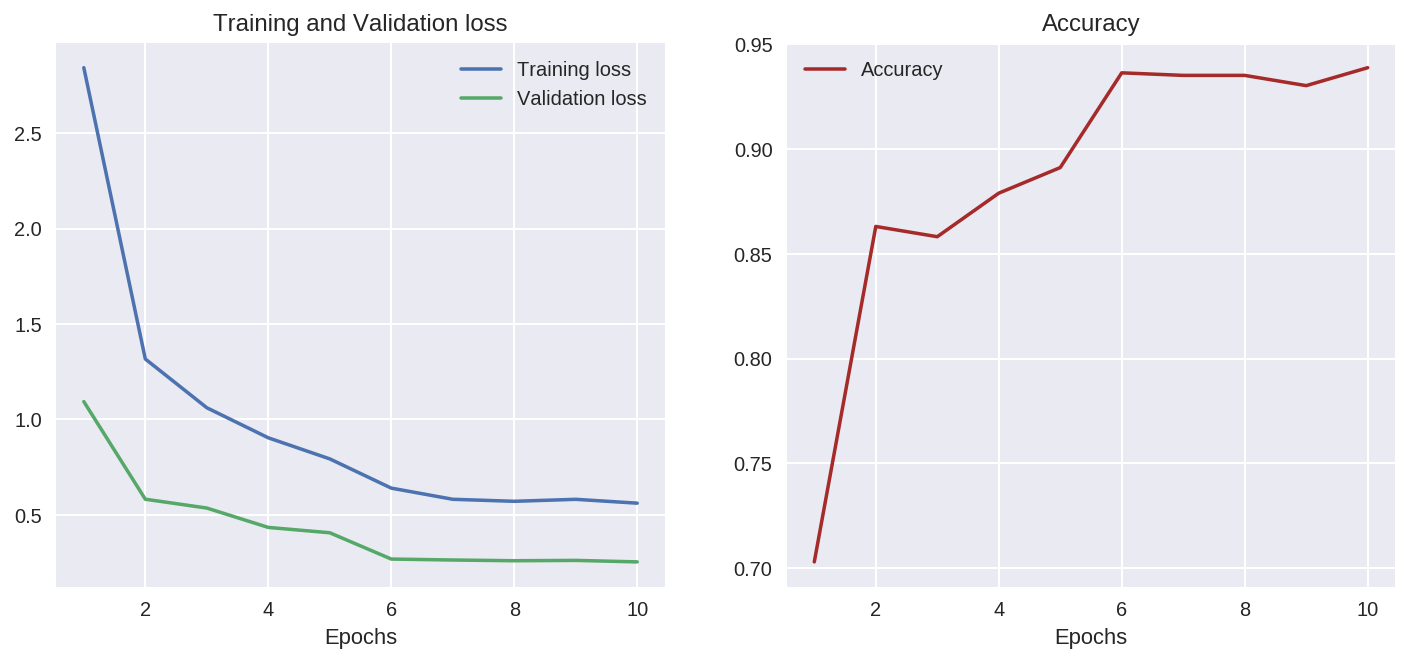

In [0]:
epoch_labels = np.arange(1, epochs + 1, 1)
plot_graphs(epoch_labels, train_losses, valid_losses, accuracies)

And then also graphs obtained during **fine-tuning** of the whole model.

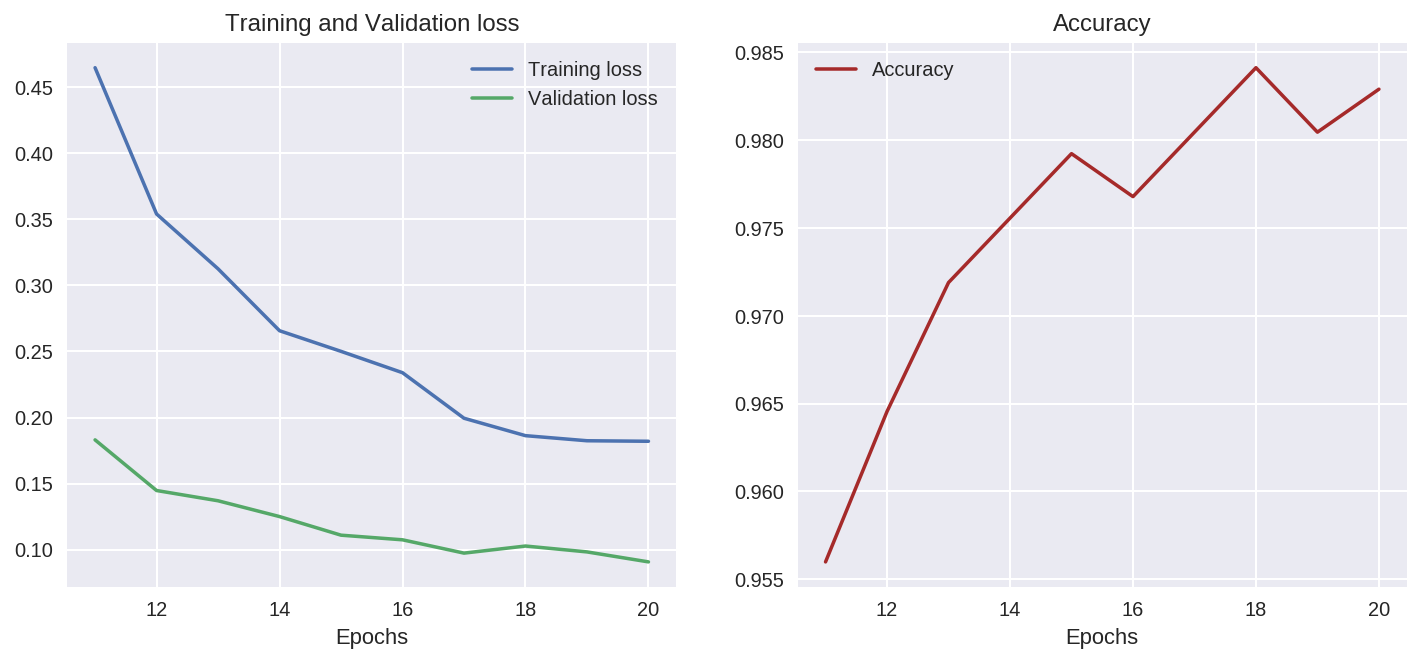

In [0]:
epoch_labels_ft = np.arange(epochs + 1, epochs + epochs_ft + 1, 1)
plot_graphs(epoch_labels_ft, train_losses_ft, valid_losses_ft, accuracies_ft)

Compute **accuracy** on **test** data. The model hasn't seen the test data yet, therefore this accuracy estimates **real-world** performance.

In [0]:
def compute_and_print_test_accuracy(model):
    """
    Computes and prints accuracy of the model on test data
    
    :param model: model used for computing accuracy
    """
    
    if train_on_gpu:
        model.cuda()
        
    model.eval()
    correct = 0;
    
    with torch.no_grad():
        for images, labels in dataloaders['test']:
            if train_on_gpu:
                images, labels = images.cuda(), labels.cuda()

            # Forward pass
            outputs = model(images)

            # Compute accuracy
            _, preds = torch.max(outputs, 1)
            equals = preds == labels.data
            correct += int(torch.sum(equals.type(torch.FloatTensor)))
  
    print('Test Accuracy: {:.2f} ({}/{})'.format(
        100. * correct / len(dataloaders['test'].dataset),
        correct, 
        len(dataloaders['test'].dataset)))
                
compute_and_print_test_accuracy(model)

Test Accuracy: 98.29 (805/819)


The training of the model went quite well, the **test accuracy is over 98% after just 20 epochs**. From the graphs we don't see any overfitting, both training and validation loss were still decreasing and we could probably train the model for a couple epochs more to get better results. 

Training loss is higher then validation loss due to dropout and data augmantation. 

## Inference
With the model trained, we can use it for inference. That means **predicting** a flower class of new images.

First we need to **preprocess** the input image the same way as the validation/testing images, i. e. by the corresponding transform, then we predict **top k** most probable classes.

In [0]:
def preprocess_image(image_path):
    """
    Loads and preprocesses an image
    
    :param image_path: path of an image
    :return: preprocessed image tensor
    """
    image = Image.open(image_path)
    tensor = data_transforms['test'](image)
    
    return tensor

In [0]:
def predict(image, model, topk = 5):
    """
    Returns topk probabilities and classes of an image predicted by a model
        
    :param image: image tensor to predict flower class
    :param model: model for the prediction
    :param topk: number of top outputs to return
    :returns: probabilities and classes of topk predictions as numpy array
    """
    model.eval()
    
    if train_on_gpu:
        image = image.cuda()
        
    with torch.no_grad():
        # If predicting only one image, add a dimension for batch size
        if len(image.shape) == 3:
            image = image.unsqueeze(0)
        output = model(image)
        ps = torch.exp(output)
        top = ps.topk(topk, dim=1)
    
    return top[0].cpu().squeeze().numpy(), top[1].cpu().squeeze().numpy()

An **example** how to predict a flower class.

Classifying: pink primrose
Predicted:
  pink primrose 98.73
  watercress 0.41
  buttercup 0.34
  wild pansy 0.31
  mallow 0.14


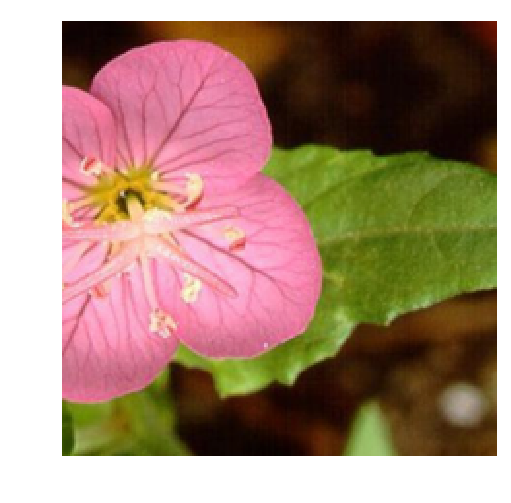

In [0]:
path = 'flower_data/test/1/image_06760.jpg'
print('Classifying: {}'.format(cat_to_name['1']))

k = 5
# Preprocess image
image = preprocess_image(path)

# Predict classes
probs, classes_idx = predict(image, model, k)

print('Predicted:')
for i in range(k):
    name = cat_to_name[idx_to_class[classes_idx[i]]]
    print('  {} {:.2f}'.format(name, 100 * probs[i]))
    
plt.imshow(unnormalize(image.numpy()).transpose((1, 2, 0)))
plt.axis('off');

### Sanity Check
Visualize outputs of the algorithm for a few images from a batch to make sure they **make sense**.

In [0]:
# Get a batch of images
images, labels = next(iter(dataloaders['test']))
if train_on_gpu:
    images, labels = images.cuda(), labels.cuda()

# Predict classes
probs, classes_idx = predict(images, model)

images = images.cpu().numpy() 
labels = labels.cpu().numpy()

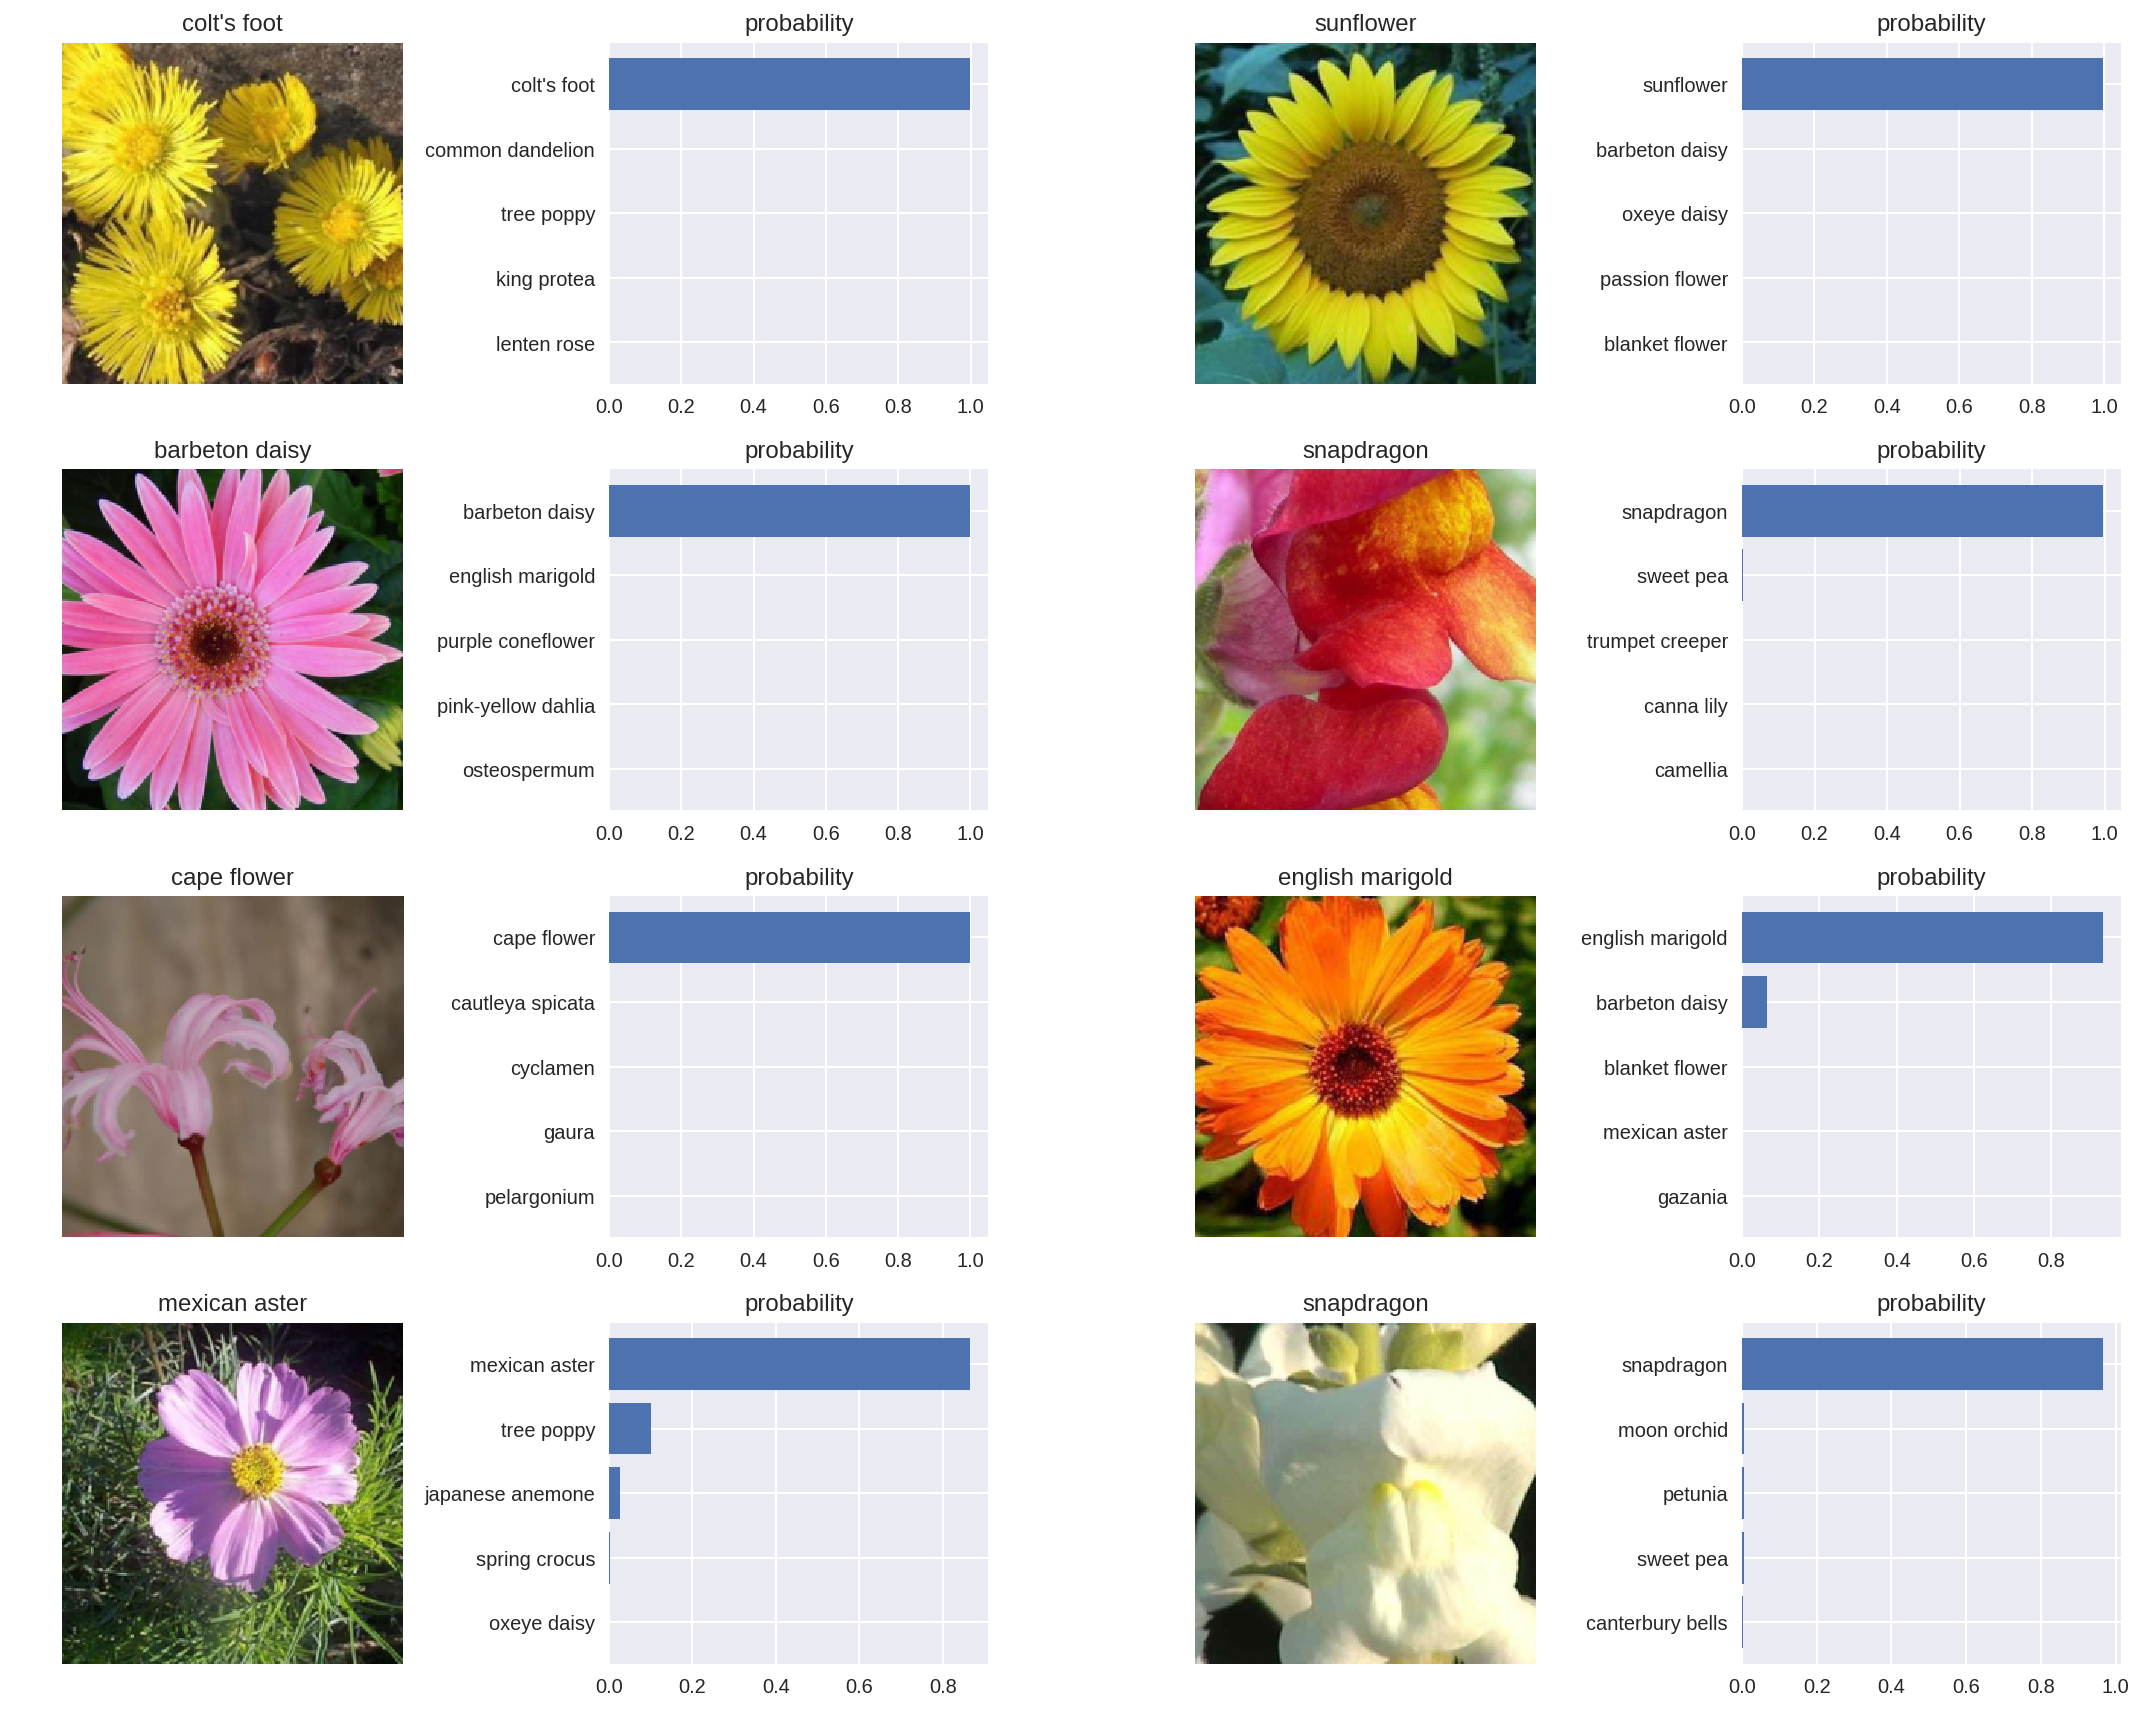

In [0]:
# Visualize results
num_of_images = 8
fig, ax = plt.subplots(4, 4, figsize=(15, 12))

for i in range(num_of_images):

    plt.sca(ax[(2*i)//4,(2*i)%4])
    plt.imshow(unnormalize(images[i]).transpose((1, 2, 0)))
    plt.title(cat_to_name[idx_to_class[labels[i]]])
    plt.axis('off')
    
    names = [cat_to_name[idx_to_class[c.item()]] for c in classes_idx[i]]
    y_pos = np.arange(len(names))
    
    plt.sca(ax[(2*i+1)//4,(2*i+1)%4])
    plt.barh(y_pos, probs[i,::-1], align='center', alpha=1)
    plt.yticks(y_pos, names[::-1])
    plt.title('probability')

    fig.tight_layout()
    
plt.show()  